# Clustering From Scratch
Applying K-Means, DBSCAN, and HDBSCAN to the provided dataset using only NumPy, Pandas, and Matplotlib.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('clustering_data.csv')
X = data[['x', 'y']].to_numpy()
data.head()

,x,y
0,262.354,90.171
1,58.571,357.793
2,210.552,263.524
3,156.131,260.007
4,135.543,388.240


In [9]:
def pairwise_distances(X):
    diff = X[:, None, :] - X[None, :, :]
    return np.sqrt(np.sum(diff * diff, axis=2))

def plot_clusters(X, labels, title):
    plt.figure(figsize=(6, 5))
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    for color, lbl in zip(colors, unique_labels):
        mask = labels == lbl
        if lbl == -1:
            plt.scatter(X[mask, 0], X[mask, 1], s=10, c=[color], marker='x', label='noise')
        else:
            plt.scatter(X[mask, 0], X[mask, 1], s=10, c=[color], label=f'cluster {lbl}')
    plt.title(title)
    plt.legend(loc='best', fontsize=8)
    plt.show()

## K-Means from Scratch
Simple iterative centroid-based clustering.

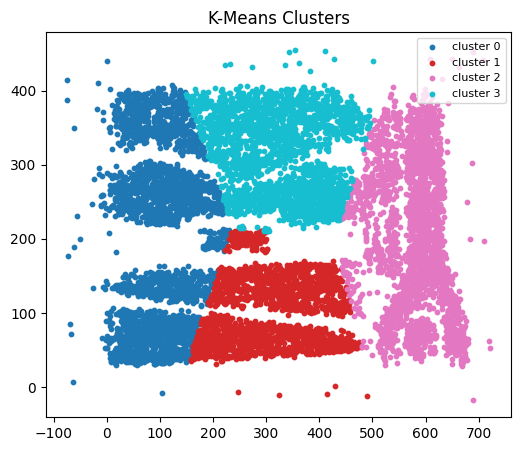

In [10]:
class KMeansScratch:
    def __init__(self, k, max_iters=100, random_state=0):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None

    def initialize_centroids(self, X):
        rng = np.random.default_rng(self.random_state)
        indices = rng.choice(len(X), size=self.k, replace=False)
        self.centroids = X[indices].copy()

    def assign_clusters(self, X):
        distances = np.linalg.norm(X[:, None, :] - self.centroids[None, :, :], axis=2)
        return np.argmin(distances, axis=1)

    def update_centroids(self, X, labels):
        new_centroids = []
        for idx in range(self.k):
            points = X[labels == idx]
            if len(points) == 0:
                new_centroids.append(self.centroids[idx])
            else:
                new_centroids.append(points.mean(axis=0))
        self.centroids = np.vstack(new_centroids)

    def fit_predict(self, X):
        self.initialize_centroids(X)
        for _ in range(self.max_iters):
            labels = self.assign_clusters(X)
            old_centroids = self.centroids.copy()
            self.update_centroids(X, labels)
            if np.allclose(old_centroids, self.centroids):
                break
        return labels

kmeans = KMeansScratch(k=4, max_iters=50, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
plot_clusters(X, kmeans_labels, 'K-Means Clusters')

## DBSCAN from Scratch
Density-based clustering that marks low-density points as noise.

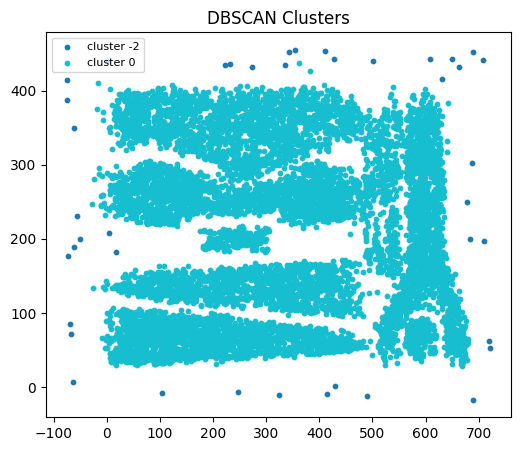

In [ ]:
class DBSCANScratch:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

    def region_query(self, X, idx):
        distances = np.linalg.norm(X - X[idx], axis=1)
        return np.where(distances <= self.eps)[0]

    def expand_cluster(self, X, labels, idx, cluster_id):
        seeds = list(self.region_query(X, idx))
        if len(seeds) < self.min_samples:
            labels[idx] = -1
            return False
        labels[idx] = cluster_id
        i = 0
        while i < len(seeds):
            point = seeds[i]
            if labels[point] == -1:
                labels[point] = cluster_id
            if labels[point] != 0:
                i += 1
                continue
            labels[point] = cluster_id
            neighbors = self.region_query(X, point)
            if len(neighbors) >= self.min_samples:
                seeds.extend([n for n in neighbors if n not in seeds])
            i += 1
        return True

    def fit_predict(self, X):
        labels = np.zeros(len(X), dtype=int)
        cluster_id = 0
        for idx in range(len(X)):
            if labels[idx] != 0:
                continue
            if self.expand_cluster(X, labels, idx, cluster_id + 1):
                cluster_id += 1
        labels[labels == 0] = -1
        return labels  # keep noise at -1, clusters start at 1; adjust to start at 0 below

dbscan = DBSCANScratch(eps=25.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
dbscan_labels = np.where(dbscan_labels == -1, -1, dbscan_labels - 1)
plot_clusters(X, dbscan_labels, 'DBSCAN Clusters')

## HDBSCAN from Scratch (simplified)
Hierarchy over density via mutual reachability distances and a stability-based cluster selection.

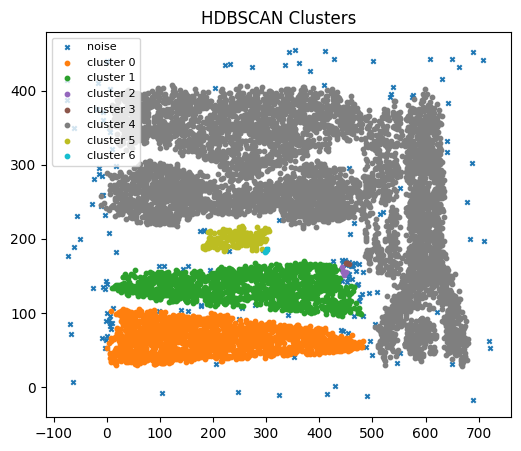

In [12]:
def core_distances(X, min_samples):
    dists = pairwise_distances(X)
    sorted_dists = np.sort(dists, axis=1)
    return sorted_dists[:, min_samples - 1]

def mutual_reachability_distances(X, min_samples):
    core = core_distances(X, min_samples)
    pairwise = pairwise_distances(X)
    return np.maximum(pairwise, np.maximum(core[:, None], core[None, :]))

def prim_mst(mreach):
    n = mreach.shape[0]
    selected = np.zeros(n, dtype=bool)
    selected[0] = True
    edges = []
    min_dist = mreach[0].copy()
    min_edge = np.zeros(n, dtype=int)
    for _ in range(n - 1):
        min_dist[selected] = np.inf
        v = np.argmin(min_dist)
        u = min_edge[v]
        w = min_dist[v]
        edges.append((u, v, w))
        selected[v] = True
        for j in range(n):
            if not selected[j] and mreach[v, j] < min_dist[j]:
                min_dist[j] = mreach[v, j]
                min_edge[j] = v
    return edges

def build_cluster_tree(n_points, edges):
    edges_sorted = sorted(edges, key=lambda x: x[2])
    next_id = n_points
    parent = {i: i for i in range(n_points)}
    size = {i: 1 for i in range(n_points)}
    birth = {i: np.inf for i in range(n_points)}
    death = {i: None for i in range(n_points)}
    children = {i: [] for i in range(n_points)}

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    for u, v, w in edges_sorted:
        ru, rv = find(u), find(v)
        if ru == rv:
            continue
        lambda_val = 1.0 / w if w > 0 else np.inf
        death[ru] = lambda_val
        death[rv] = lambda_val
        parent[ru] = next_id
        parent[rv] = next_id
        birth[next_id] = lambda_val
        size[next_id] = size[ru] + size[rv]
        death[next_id] = None
        children[next_id] = [ru, rv]
        parent[next_id] = next_id
        size[ru] = size[rv] = 0
        next_id += 1

    root = find(0)
    death[root] = 0.0
    stability = {}
    for cid in birth.keys():
        if death[cid] is None:
            continue
        stability[cid] = (death[cid] - birth.get(cid, 0.0)) * max(size.get(cid, 0), 1)
    return root, children, stability

def select_clusters(root, children, stability):
    def recurse(node):
        if node not in children or len(children[node]) == 0:
            return []
        selected_children = []
        for child in children[node]:
            selected_children.extend(recurse(child))
        child_score = sum(stability.get(c, 0.0) for c in selected_children)
        self_score = stability.get(node, 0.0)
        if self_score >= child_score:
            return [node]
        return selected_children
    return recurse(root)

def label_points(n_points, selected, children):
    labels = np.full(n_points, -1, dtype=int)
    cluster_id = 0
    def assign(node, cid):
        if node < n_points:
            labels[node] = cid
            return
        for child in children.get(node, []):
            assign(child, cid)
    for node in selected:
        assign(node, cluster_id)
        cluster_id += 1
    return labels

def hdbscan_scratch(X, min_samples=5):
    mreach = mutual_reachability_distances(X, min_samples)
    edges = prim_mst(mreach)
    root, children, stability = build_cluster_tree(len(X), edges)
    selected = select_clusters(root, children, stability)
    labels = label_points(len(X), selected, children)
    return labels

hdbscan_labels = hdbscan_scratch(X, min_samples=5)
plot_clusters(X, hdbscan_labels, 'HDBSCAN Clusters')

## Quick Comparison
Basic summary stats for the three runs.

In [13]:
def cluster_summary(labels):
    counts = pd.Series(labels).value_counts().sort_index()
    n_clusters = (counts.index != -1).sum()
    n_noise = counts.get(-1, 0)
    return n_clusters, n_noise, counts.to_dict()

k_summary = cluster_summary(kmeans_labels)
d_summary = cluster_summary(dbscan_labels)
h_summary = cluster_summary(hdbscan_labels)

print('K-Means clusters:', k_summary[0])
print('DBSCAN clusters:', d_summary[0], 'noise:', d_summary[1])
print('HDBSCAN clusters:', h_summary[0], 'noise:', h_summary[1])

K-Means clusters: 4
DBSCAN clusters: 2 noise: 0
HDBSCAN clusters: 7 noise: 161


## Metrics
Simple internal metrics (silhouette, Davies-Bouldin, Calinski-Harabasz). Noise points (-1) are ignored for the metrics that require cluster membership.

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def score_all(X, labels):
    mask = labels >= 0
    Xc = X[mask]
    lc = labels[mask]
    unique = np.unique(lc)
    if len(Xc) == 0 or len(unique) < 2:
        return {
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan
        }
    silhouette = silhouette_score(Xc, lc, sample_size=min(len(Xc), 4000), random_state=0) if len(Xc) > 50 else silhouette_score(Xc, lc)
    db = davies_bouldin_score(Xc, lc)
    ch = calinski_harabasz_score(Xc, lc)
    return {'silhouette': float(silhouette), 'davies_bouldin': float(db), 'calinski_harabasz': float(ch)}

metrics = {
    'kmeans': score_all(X, kmeans_labels),
    'dbscan': score_all(X, dbscan_labels),
    'hdbscan': score_all(X, hdbscan_labels)
}
metrics

{'kmeans': {'silhouette': 0.40543181313469406,
  'davies_bouldin': 0.812239817585373,
  'calinski_harabasz': 10456.643724131853},
 'dbscan': {'silhouette': nan,
  'davies_bouldin': nan,
  'calinski_harabasz': nan},
 'hdbscan': {'silhouette': -0.30014436089858465,
  'davies_bouldin': 1.8953911162340125,
  'calinski_harabasz': 551.3200973901791}}